In [2]:
import os 
import caer
import canaro
import numpy as np
import cv2 as cv
import gc 
import sklearn.model_selection as skm

In [3]:
#gpu set up
import tensorflow as tf
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6497309890377855857
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3134364059
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4656816542880382254
physical_device_desc: "device: 0, name: GeForce GTX 1050, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [4]:
IMG_SIZE = (80,80)
channels = 1
char_path = r'C:\Users\user\Documents\GitHub\SimpsonsCapstone\simpsons\simpsons_dataset'

In [5]:
char_dict = {}

for char in os.listdir(char_path):
    char_dict[char] = len(os.listdir(os.path.join(char_path, char)))

# sort in descending order
char_dict = caer.sort_dict(char_dict, descending=True)
char_dict

[('homer_simpson', 2246),
 ('ned_flanders', 1454),
 ('moe_szyslak', 1452),
 ('lisa_simpson', 1354),
 ('bart_simpson', 1342),
 ('marge_simpson', 1291),
 ('krusty_the_clown', 1206),
 ('principal_skinner', 1194),
 ('charles_montgomery_burns', 1193),
 ('milhouse_van_houten', 1079),
 ('chief_wiggum', 986),
 ('abraham_grampa_simpson', 913),
 ('sideshow_bob', 877),
 ('apu_nahasapeemapetilon', 623),
 ('kent_brockman', 498),
 ('comic_book_guy', 469),
 ('edna_krabappel', 457),
 ('nelson_muntz', 358),
 ('lenny_leonard', 310),
 ('mayor_quimby', 246),
 ('waylon_smithers', 181),
 ('maggie_simpson', 128),
 ('groundskeeper_willie', 121),
 ('barney_gumble', 106),
 ('selma_bouvier', 103),
 ('carl_carlson', 98),
 ('ralph_wiggum', 89),
 ('patty_bouvier', 72),
 ('martin_prince', 71),
 ('professor_john_frink', 65),
 ('snake_jailbird', 55),
 ('cletus_spuckler', 47),
 ('rainier_wolfcastle', 45),
 ('agnes_skinner', 42),
 ('simpsons_dataset', 42),
 ('sideshow_mel', 40),
 ('otto_mann', 32),
 ('fat_tony', 27),
 (

In [6]:
characters = []
count = 0
for i in char_dict:
    characters.append(i[0])
    count +=1
    if count >=10:
        break
characters

['homer_simpson',
 'ned_flanders',
 'moe_szyslak',
 'lisa_simpson',
 'bart_simpson',
 'marge_simpson',
 'krusty_the_clown',
 'principal_skinner',
 'charles_montgomery_burns',
 'milhouse_van_houten']

In [7]:
# create training data
train = caer.preprocess_from_dir(char_path, characters, channels=channels, IMG_SIZE=IMG_SIZE, isShuffle=True)

[INFO] Could not find a file to load from. Generating the training data
----------------------------------------------
1 - homer_simpson
2 - homer_simpson
3 - homer_simpson
4 - homer_simpson
5 - homer_simpson
6 - homer_simpson
7 - homer_simpson
8 - homer_simpson
9 - homer_simpson
10 - homer_simpson
11 - homer_simpson
12 - homer_simpson
13 - homer_simpson
14 - homer_simpson
15 - homer_simpson
16 - homer_simpson
17 - homer_simpson
18 - homer_simpson
19 - homer_simpson
20 - homer_simpson
21 - homer_simpson
22 - homer_simpson
23 - homer_simpson
24 - homer_simpson
25 - homer_simpson
26 - homer_simpson
27 - homer_simpson
28 - homer_simpson
29 - homer_simpson
30 - homer_simpson
31 - homer_simpson
32 - homer_simpson
33 - homer_simpson
34 - homer_simpson
35 - homer_simpson
36 - homer_simpson
37 - homer_simpson
38 - homer_simpson
39 - homer_simpson
40 - homer_simpson
41 - homer_simpson
42 - homer_simpson
43 - homer_simpson
44 - homer_simpson
45 - homer_simpson
46 - homer_simpson
47 - homer_simps

C:\ProgramData\Anaconda3\envs\tf_gpu\lib\site-packages\caer\core.py:72: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(obj, dtype=dtype, order=order)


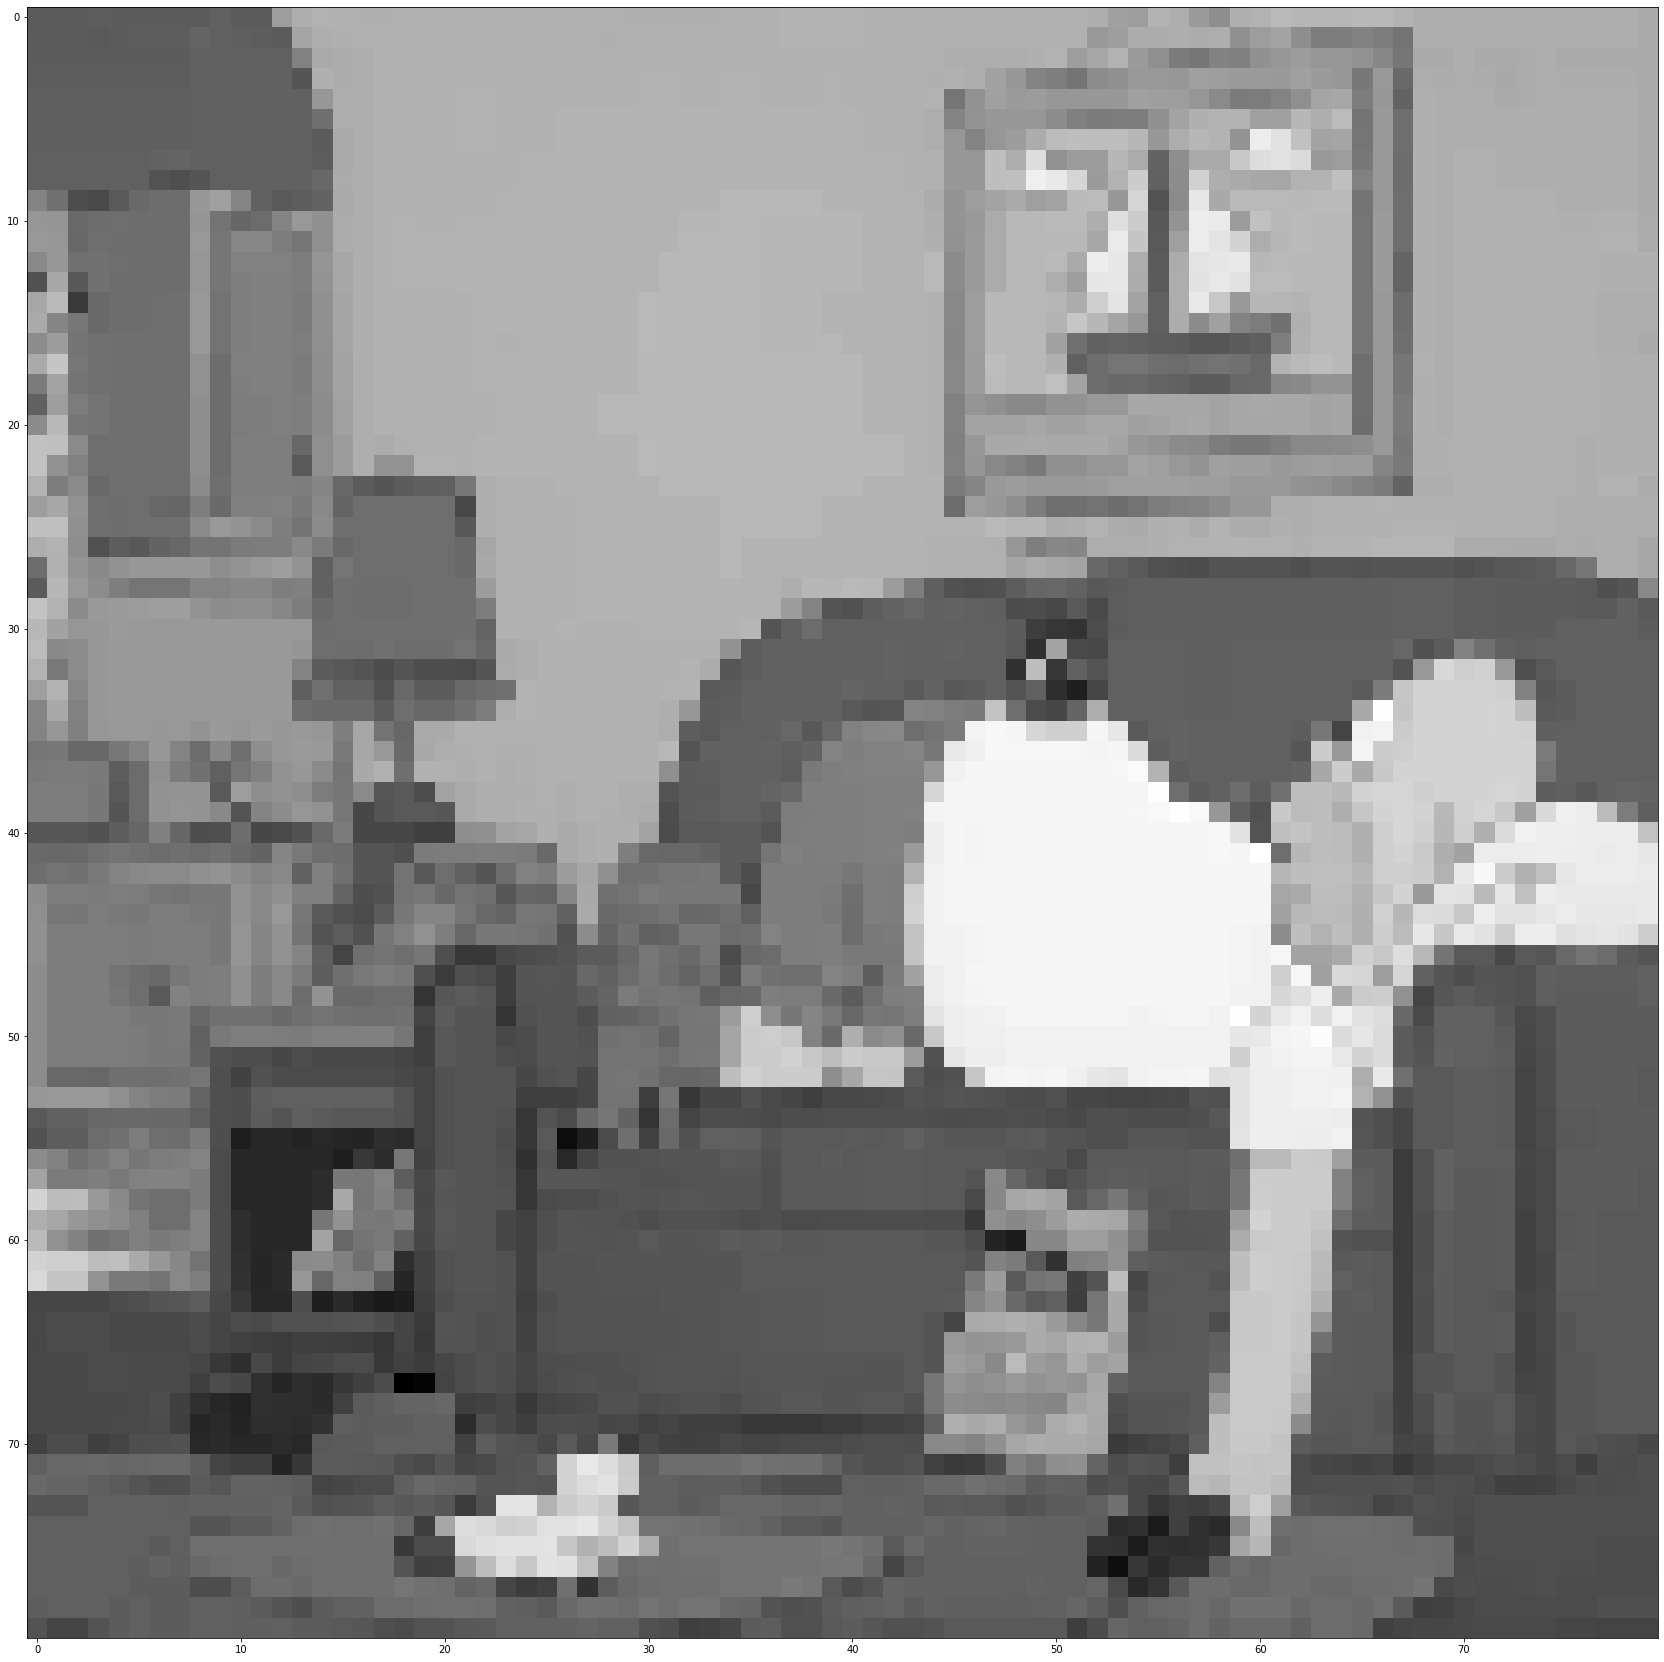

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(30,30))
plt.imshow(train[0][0], cmap="gray")
plt.show()

In [9]:
featureSet, labels = caer.sep_train(train, IMG_SIZE=IMG_SIZE)

In [10]:
from tensorflow.keras.utils import to_categorical
# normalize the feature set ==> (0,1)
featureSet = caer.normalize(featureSet)
labels = to_categorical(labels, len(characters))


In [11]:
split_data = skm.train_test_split(featureSet, labels, test_size=.2)
x_train, x_val, y_train, y_val = (np.array(item) for item in split_data)

In [12]:
del train
del featureSet
del labels
gc.collect()

3350

In [13]:
BATCH_SIZE = 32
EPOCHS = 10

In [14]:
# image data generator
datagen = canaro.generators.imageDataGenerator()
train_gen = datagen.flow(x_train, y_train, batch_size=BATCH_SIZE)

In [15]:
#model
model = canaro.models.createSimpsonsModel(IMG_SIZE=IMG_SIZE, channels=channels, output_dim=len(characters), 
                                         loss='binary_crossentropy', decay=1e-7, learning_rate=0.001, momentum=0.9,
                                         nesterov=True)

In [16]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 80, 80, 32)        320       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 78, 78, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 39, 39, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 39, 39, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 39, 39, 64)        18496     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 37, 37, 64)        36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 18, 18, 64)       

In [ ]:
# Training the model

from tensorflow.keras.callbacks import LearningRateScheduler
callbacks_list = [LearningRateScheduler(canaro.lr_schedule)]
training = model.fit(train_gen,
                    steps_per_epoch=len(x_train)//BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(x_val,y_val),
                    validation_steps=len(y_val)//BATCH_SIZE,
                    callbacks = callbacks_list)

Epoch 1/10
345/345 [==============================] - 22s 65ms/step - loss: 0.2930 - accuracy: 0.2958 - val_loss: 0.2881 - val_accuracy: 0.3344
Epoch 2/10
345/345 [==============================] - 21s 60ms/step - loss: 0.2915 - accuracy: 0.3010
Epoch 3/10
345/345 [==============================] - 21s 60ms/step - loss: 0.2895 - accuracy: 0.3080
Epoch 4/10
345/345 [==============================] - 21s 60ms/step - loss: 0.2867 - accuracy: 0.3184
Epoch 5/10
345/345 [==============================] - 21s 60ms/step - loss: 0.2816 - accuracy: 0.3332
Epoch 6/10
345/345 [==============================] - 21s 60ms/step - loss: 0.2776 - accuracy: 0.3536
Epoch 7/10
345/345 [==============================] - 21s 60ms/step - loss: 0.2732 - accuracy: 0.3680
Epoch 8/10
133/345 [==========>...................] - ETA: 12s - loss: 0.2696 - accuracy: 0.3731

In [18]:
characters

['homer_simpson',
 'ned_flanders',
 'moe_szyslak',
 'lisa_simpson',
 'bart_simpson',
 'marge_simpson',
 'krusty_the_clown',
 'principal_skinner',
 'charles_montgomery_burns',
 'milhouse_van_houten']

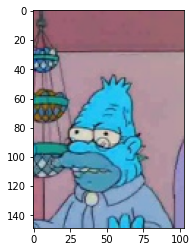

In [28]:
img = cv.imread('simpsons/kaggle_simpson_testset/kaggle_simpson_testset/abraham_grampa_simpson_0.jpg')
plt.imshow(img)
plt.show()

In [32]:
def prepare(image):
    image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    image = cv.resize(image, IMG_SIZE)
    image = caer.reshape(image, IMG_SIZE, 1)
    return image

In [33]:
predictions = model.predict(prepare(img))

In [34]:
# Getting class with the highest probability
print(characters[np.argmax(predictions[0])])

lisa_simpson
